In [5]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


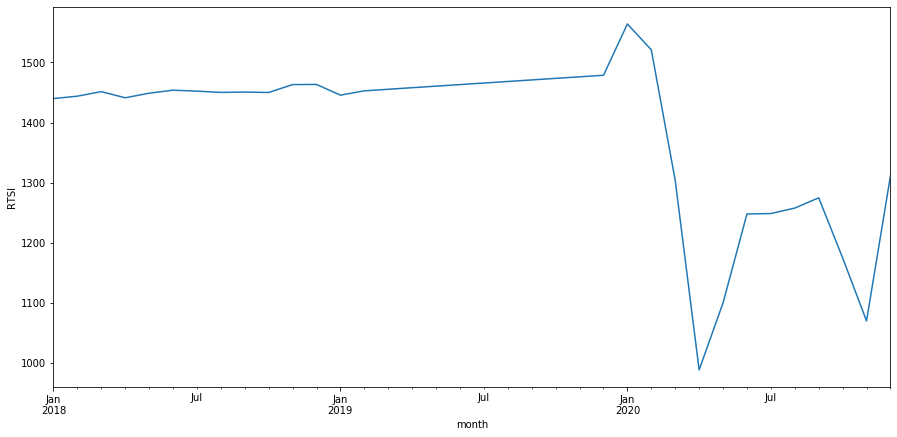

In [6]:
df3 = pd.read_csv('C:/Users/user/Desktop/ARIMA(RTSI)/VASYA3.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
df3.id.plot()
plt.ylabel('RTSI')
pylab.show()

Критерий Дики-Фуллера: p=0.535313


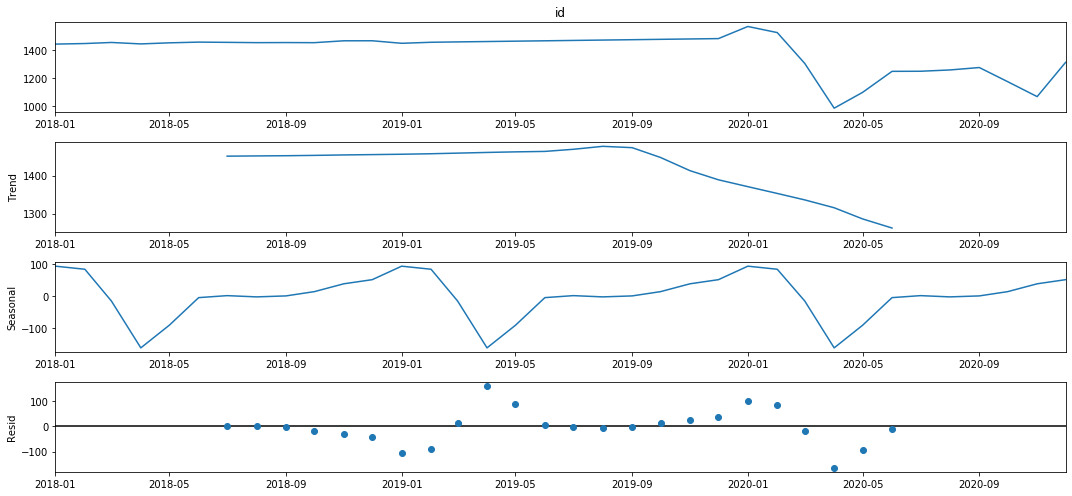

In [8]:
sm.tsa.seasonal_decompose(df3.id,period=12).plot()
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df3.id)[1])

Оптимальный параметр преобразования Бокса-Кокса: 8.703843
Критерий Дики-Фуллера: p=0.775041


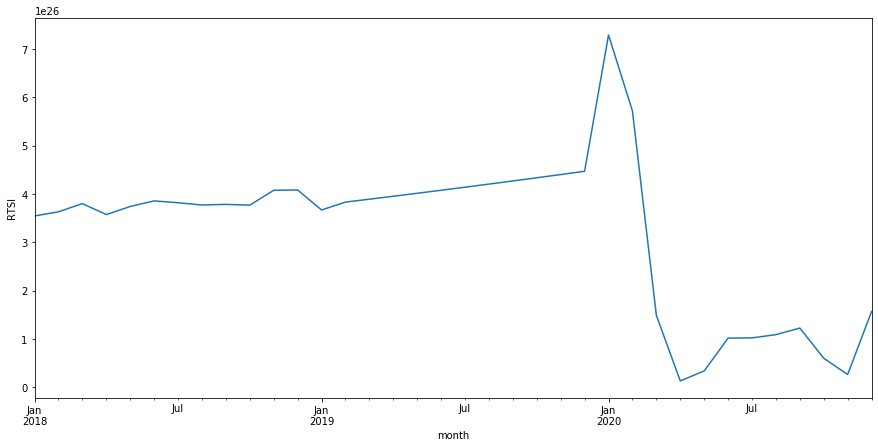

In [10]:
df3['sales_box'], lmbda = stats.boxcox(pd.to_numeric(df3.id))
plt.figure(figsize(15,7))
df3.sales_box.plot()
plt.ylabel(u'RTSI')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df3.sales_box)[1])

Критерий Дики-Фуллера: p=0.868952


<Figure size 1080x720 with 0 Axes>

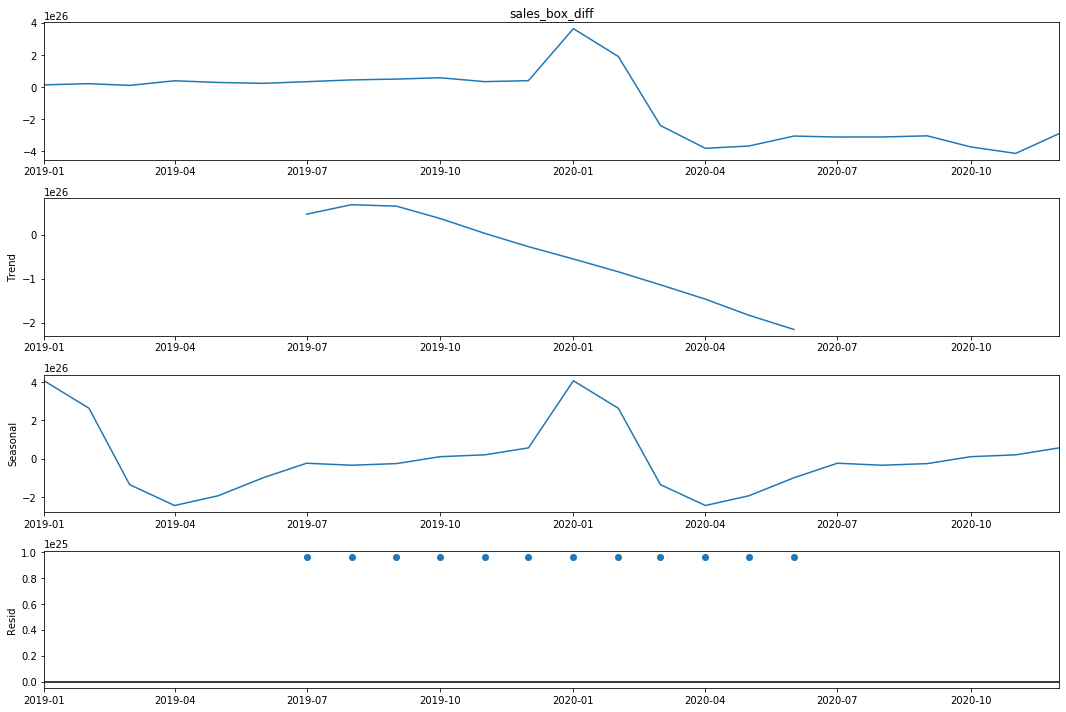

In [11]:
df3['sales_box_diff'] = df3.sales_box - df3.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df3.sales_box_diff[12:],period=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df3.sales_box_diff[12:])[1])

In [18]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [19]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [21]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df3.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 23.8 s


In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
26  (2, 0, 1, 0)  2824.653379
14  (1, 0, 1, 0)  2825.516409
6   (0, 1, 1, 0)  2826.289453
27  (2, 0, 1, 1)  2826.651014
38  (3, 0, 1, 0)  2826.988372


In [23]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          sales_box   No. Observations:                   36
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -1408.327
Date:                            Sat, 12 Dec 2020   AIC                           2824.653
Time:                                    18:18:43   BIC                           2829.195
Sample:                                01-01-2018   HQIC                          2825.796
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6156      0.271      2.268      0.023       0.084       1.148
ar.L2         -0.2640      0.649   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


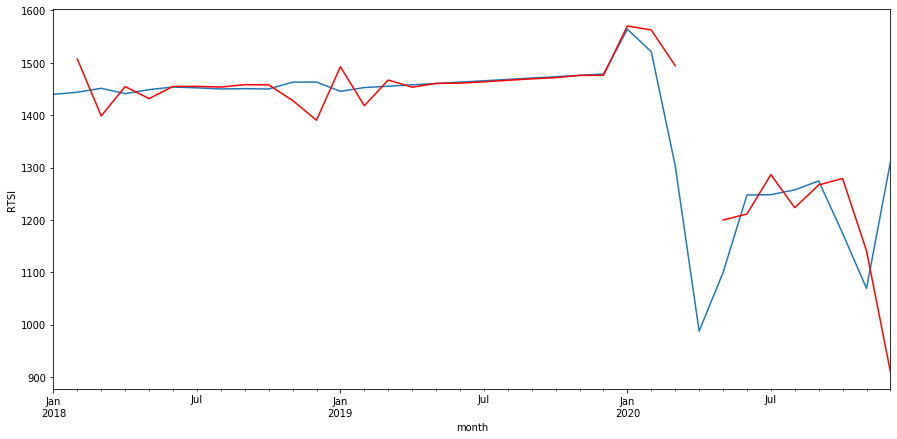

In [33]:
df3['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df3.id.plot()
df3.model[1:].plot(color='r')
plt.ylabel('RTSI')
pylab.show()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


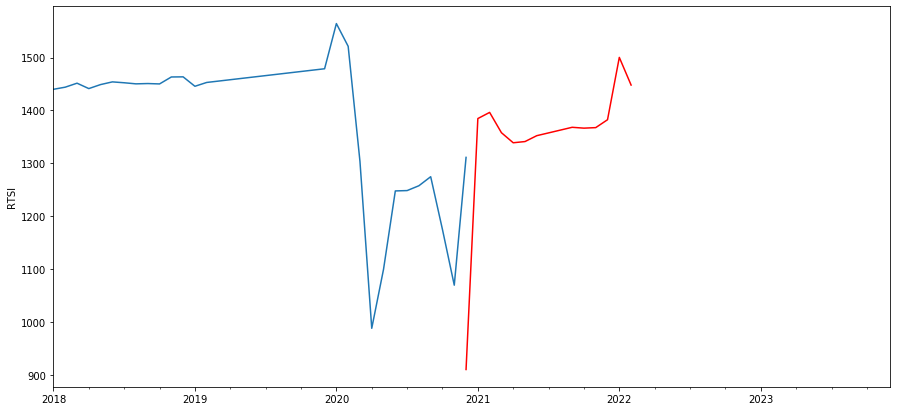

In [35]:
df4= df3[['id']]
date_list = [datetime.datetime.strptime("2021-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df4.columns)
df4 = pd.concat([df4, future])
df4['forecast'] = invboxcox(best_model.predict(start=35, end=50), lmbda)

plt.figure(figsize(15,7))
df4.id.plot()
df4.forecast.plot(color='r')
plt.ylabel('RTSI')
pylab.show()